<a href="https://colab.research.google.com/github/Son0208/prac_class/blob/main/Sentimental_Analysis_Tweet_Covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/c/sentiment-analysis-of-covid-19-related-tweets/overview

https://www.kaggle.com/sagarjiyani/toxic-comment-classifier

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Embedding, Input , Activation
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import initializers, optimizers, layers
from sklearn.metrics import  roc_auc_score

import warnings
warnings.simplefilter(action="ignore")

In [2]:
!git clone https://github.com/Son0208/repository.git

fatal: destination path 'repository' already exists and is not an empty directory.


In [3]:
train = pd.read_csv('repository/training.csv')
test = pd.read_csv('repository/validation.csv')

In [4]:
train = train[['ID','Tweet']].join(train.Labels.str.join("|").str.get_dummies())
train.rename(columns = {' ' : '10'}, inplace = True)  # train.columns = ['ID', 'Tweet', '10', '0','1','2','3','4','5','6','7','8','9']
train = train[['ID','Tweet','0','1','2','3','4','5','6','7','8','9','10']]

In [5]:
train.head()

,ID,Tweet,0,1,2,3,4,5,6,7,8,9,10
0,1,NO JOKE I WILL HOP ON A PLANE RN! (Well after ...,1,1,0,0,0,0,0,0,0,0,1
1,2,BanMediaHouse whose is responsible for spreadi...,0,0,0,0,0,0,1,0,0,0,0
2,3,Im waiting for someone to say to me that all t...,0,0,0,1,1,0,0,0,0,0,1
3,4,He is a liar. Proven day night. Time again. Li...,0,0,0,0,0,0,1,0,0,0,0
4,5,"NEW: U.S. CoronaVirus death toll reaches 4,000...",0,0,0,0,0,0,0,0,1,0,0


In [6]:
test.head()

,ID,Tweet
0,5001,Forgot to a math test and I was failing but my...
1,5002,Corona effected came from Delhi in Bihar lakhi...
2,5003,Make CORONA END NA
3,5004,Imagine if the coronavirus pandemic was a big ...
4,5005,Howdy Ana. Where can I get married during the ...


In [7]:
train['Tweet'][0]

'NO JOKE I WILL HOP ON A PLANE RN! (Well after COVID19 lol)'

In [8]:
classes = ['0','1','2','3','4','5','6','7','8','9','10']
targets = train[classes].values

train_sentences = train['Tweet']
test_sentences = test['Tweet']

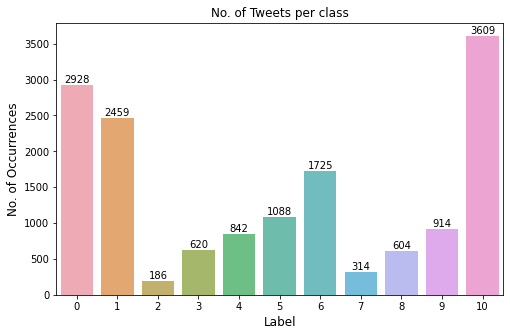

In [9]:
value_counts = train[classes].sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(value_counts.index, value_counts.values, alpha=0.8)

plt.title("No. of Tweets per class" )
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Label', fontsize=12)

rects = ax.patches
labels = value_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

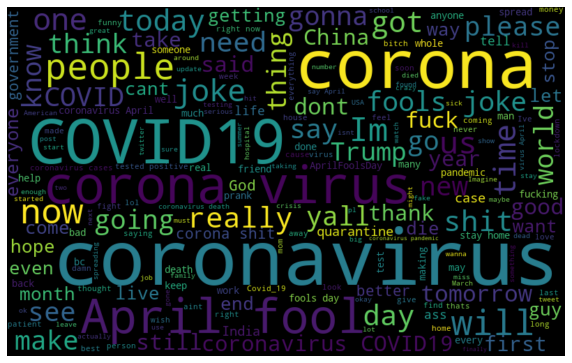

In [10]:
from wordcloud import WordCloud

all_words = ' '.join([text for text in train['Tweet'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(train_sentences))

In [12]:
tokenized_train = tokenizer.texts_to_sequences(train_sentences)
tokenized_test = tokenizer.texts_to_sequences(test_sentences)

print(tokenized_train[1])

[4187, 2168, 7, 1316, 13, 315, 298, 8, 1530, 953, 11, 12, 112, 2, 392]


In [13]:
print(tokenizer.word_index)
len(tokenizer.word_index)

{'the': 1, 'corona': 2, 'to': 3, 'coronavirus': 4, 'i': 5, 'a': 6, 'is': 7, 'and': 8, 'of': 9, 'covid19': 10, 'in': 11, 'this': 12, 'for': 13, 'my': 14, 'virus': 15, 'april': 16, 'that': 17, 'you': 18, 'be': 19, 'it': 20, 'on': 21, 'fools': 22, 'just': 23, 'me': 24, 'all': 25, 'if': 26, 'are': 27, 'so': 28, 'we': 29, 'not': 30, 'with': 31, 'was': 32, 'have': 33, 'from': 34, 'about': 35, 'out': 36, 'now': 37, 'can': 38, 'im': 39, 'like': 40, 'people': 41, 'has': 42, 'at': 43, 'us': 44, 'joke': 45, 'get': 46, 'will': 47, 'up': 48, 'but': 49, 'no': 50, 'its': 51, 'shit': 52, 'new': 53, 'cases': 54, 'they': 55, 'as': 56, 'an': 57, 'one': 58, 'how': 59, 'go': 60, 'got': 61, 'what': 62, 'day': 63, 'by': 64, 'or': 65, 'covid': 66, 'your': 67, 'do': 68, 'who': 69, 'when': 70, 'say': 71, 'time': 72, 'gonna': 73, '19': 74, 'really': 75, 'please': 76, 'over': 77, 'today': 78, 'tomorrow': 79, 'he': 80, 'going': 81, 'more': 82, 'dont': 83, 'stay': 84, 'know': 85, 'world': 86, 'deaths': 87, 'yall': 

9758

Tweet Maximum Length : 31
Tweet Average Legnth : 16.035200


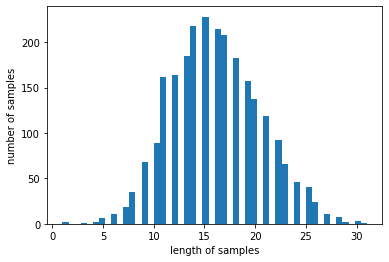

In [14]:
print('Tweet Maximum Length : %d' % max(len(l) for l in tokenized_test))
print('Tweet Average Legnth : %f' % (sum(map(len, tokenized_test))/len(tokenized_test)))
plt.hist([len(s) for s in tokenized_test], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
maxlen = 31
X_train = pad_sequences(tokenized_train, maxlen = maxlen)
X_test = pad_sequences(tokenized_test, maxlen = maxlen)

In [16]:
embed_size = 32
maxlen = 31
max_features = len(tokenizer.word_index)+1

inp = Input(shape = (maxlen, ))
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(11, activation="sigmoid")(x)

In [17]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
          optimizer= "adam",
          metrics=[f1])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 31, 32)            312288    
_________________________________________________________________
lstm_layer (LSTM)            (None, 31, 60)            22320     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

In [19]:
batch_size = 32
epochs = 20
results = model.fit(X_train, targets, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/20
125/125 [==============================] - 5s 22ms/step - loss: 0.5206 - f1: 0.5254 - val_loss: 0.4754 - val_f1: 0.5046
Epoch 2/20
125/125 [==============================] - 2s 17ms/step - loss: 0.4787 - f1: 0.5469 - val_loss: 0.4736 - val_f1: 0.5046
Epoch 3/20
125/125 [==============================] - 2s 17ms/step - loss: 0.4752 - f1: 0.5581 - val_loss: 0.4715 - val_f1: 0.5100
Epoch 4/20
125/125 [==============================] - 2s 17ms/step - loss: 0.4672 - f1: 0.5722 - val_loss: 0.4618 - val_f1: 0.5876
Epoch 5/20
125/125 [==============================] - 2s 17ms/step - loss: 0.4331 - f1: 0.6161 - val_loss: 0.4379 - val_f1: 0.5854
Epoch 6/20
125/125 [==============================] - 2s 17ms/step - loss: 0.3944 - f1: 0.6508 - val_loss: 0.4394 - val_f1: 0.5829
Epoch 7/20
125/125 [==============================] - 2s 17ms/step - loss: 0.3629 - f1: 0.6885 - val_loss: 0.4442 - val_f1: 0.6054
Epoch 8/20
125/125 [==============================] - 2s 16ms/step - loss: 0.3344 -

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


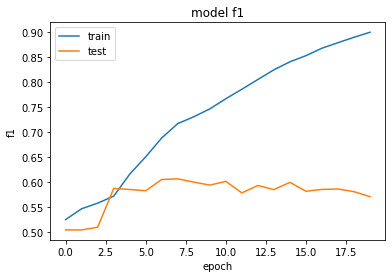

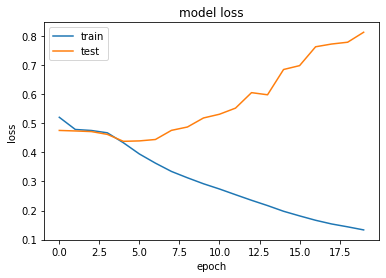

In [20]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['f1'])
plt.plot(results.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
prediction = model.predict(X_test)
prediction = (prediction>0.5)
prediction = pd.DataFrame(prediction)
prediction = prediction.applymap(lambda x: 1 if x else 0)
prediction

,0,1,2,3,4,5,6,7,8,9,10
0,1,1,0,0,0,1,0,0,0,0,1
1,0,0,0,0,1,0,0,0,1,0,1
2,1,1,0,0,0,0,0,0,0,0,1
3,1,1,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2495,0,0,0,0,0,0,0,0,1,1,1
2496,0,0,0,0,0,1,1,0,0,0,1
2497,1,1,0,0,0,0,0,0,0,0,1
2498,1,1,0,0,0,0,0,0,0,0,0


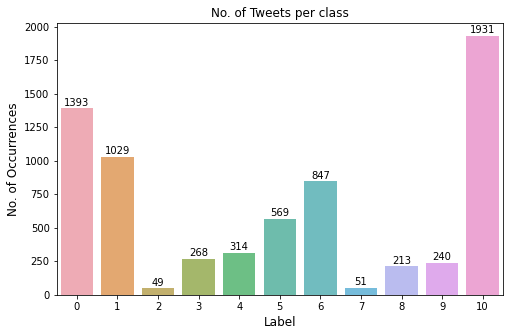

In [22]:
value_counts = prediction.sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(value_counts.index, value_counts.values, alpha=0.8)

plt.title("No. of Tweets per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Label', fontsize=12)

rects = ax.patches
labels = value_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [23]:
prediction['Labels'] = 0

classes = list(map(int, classes))

for row in range(2500) :
    one_row = []
    for cat in classes :
        if int(prediction[row:row+1][cat].values) == 1 :
            one_row.append(cat)
    prediction.Labels[row] = ' '.join(map(str,one_row))

prediction=prediction[['Labels']]
prediction

,Labels
0,0 1 5 10
1,4 8 10
2,0 1 10
3,0 1
4,0 1 9 10
...,...
2495,8 9 10
2496,5 6 10
2497,0 1 10
2498,0 1


In [24]:
submission = pd.concat([test, prediction], axis=1).drop(['Tweet'],axis=1)
submission

,ID,Labels
0,5001,0 1 5 10
1,5002,4 8 10
2,5003,0 1 10
3,5004,0 1
4,5005,0 1 9 10
...,...,...
2495,7496,8 9 10
2496,7497,5 6 10
2497,7498,0 1 10
2498,7499,0 1


In [25]:
submission['Labels'].isnull().sum()

0

In [26]:
submission.dtypes

ID         int64
Labels    object
dtype: object

In [27]:
submission.to_csv('submission.csv', index=False)

In [28]:
#from google.colab import drive
#drive.mount('/content/gdrive')

# prediction.set_index(test['ID'],inplace=True)
# prediction = prediction[prediction==1].stack().reset_index().drop(0,1)
# prediction = pd.concat([prediction,test[['ID']]]).reset_index()
# prediction = prediction.replace(np.nan, '', regex=True)
# prediction = prediction.assign(level_1=prediction.level_1.astype(str)).groupby('ID').level_1.apply(' '.join).reset_index()
# prediction = prediction.replace('.0', '', regex=True)
# prediction.rename(columns = {'level_1' : 'Labels'}, inplace = True)
# prediction